# 一、模型融合目标

- 对于多种调参完成的模型进行融合。
- 完成对于多种模型的融合，提交融合结果并打卡。

# 二、内容介绍

模型融合是比赛后期一个重要的环节。大体来说，有如下的类型方式：

1. 简单加权融合：
    - 回归（分类概率）：算术平均融合（Arithmetic Mean），几何平均融合（Geometric Mean）；
    - 分类：投票（Voting）；
    - 综合：排序融合（Rank Averaging），log融合；
2. stacking/blending：
    - 构建多层模型，并利用预测结果再拟合预测。
3. boosting/bagging（在 XGBoost，AdaBoost，GBDT 中已经用到）：
    - 多树的提升方法；

# 三、Stacking 相关理论介绍

## 什么是 stacking

简单来说，stacking 就是当用初始训练数据学习出若干个基学习器后，将这几个学习器的预测结果作为新的训练集，来学习一个新的学习器。

![Concept Diagram of Stacking](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448793231_6TygjXwjNb.jpg)

将个体学习器结合在一起的时候，使用的方法叫做 **结合策略**。对于分类问题，我们可以使用投票法来选择输出最多的类。对于回归问题，我们可以将分类器输出的结果求平均值。

上面说的 **投票法** 和 **平均法** 都是很有效的结合策略。还有一种结合策略是使用另外一个机器学习算法来将个体机器学习器的结果结合在一起，这个方法就是 **stacking**。

在 stacking 方法中，我们把个体学习器叫做 **初级学习器**，用于结合的学习器叫做 **次级学习器** 或 **元学习器（meta-learner）**，次级学习器用于训练的数据叫做 **次级训练集**。次级训练集是在训练集上用初级学习器得到的。

## 如何进行 stacking

算法示意图如下：

![Stacking 算法](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448806789_1ElRtHaacw.jpg)

> 引用自 西瓜书《机器学习》

- 过程 1-3 是训练出来个体学习器，也就是初级学习器。
- 过程 5-9 是使用训练出来的个体学习器得来的预测结果，这个预测的结果当做次级学习器的训练集。
- 过程 11 是用初级学习器预测的结果训练出次级学习器，得到我们最后训练的模型。

## Stacking 的方法讲解

首先，我们先从一种“不那么正确”但是容易懂的 Stacking 方法讲起。

Stacking 模型本质上是一种分层的结构，这里简单起见，只分析二级 Stacking。假设我们有 2 个基模型 Model1_1、Model1_2 和 一个次级模型 Model2。

**Step 1**：基模型 Model1_1，对训练集 train 训练，然后用于预测 train 和 test 的标签列，分别是 P1，T1

Model1_1 模型训练：
$$
\left\{
    \begin{matrix}
        \vdots \\
        X_{train} \\
        \vdots
    \end{matrix}
\right\}
\substack{
    Model1\_1\;Train \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        Y_{true} \\
        \vdots
    \end{matrix}
\right\}
$$

训练后的模型 Model1_1 分别在 train 和 test 上预测，得到预测标签分别是 P1, T1
$$
\left\{
    \begin{matrix}
        \vdots \\
        X_{train} \\
        \vdots
    \end{matrix}
\right\}
\substack{
    Model1\_1\;Predict \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        P_1 \\
        \vdots
    \end{matrix}
\right\}
$$

$$
\left\{
    \begin{matrix}
        \vdots \\
        X_{test} \\
        \vdots
    \end{matrix}
\right\}
\substack{
    Model1\_1\;Predict \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        T_1 \\
        \vdots
    \end{matrix}
\right\}
$$

**Step 2**：基模型 Model1_2，对训练集 train 训练，然后用于预测 train 和 test 的标签列，分别是 P2，T2

Model1_2 模型训练：
$$
\left\{
    \begin{matrix}
        \vdots \\
        X_{train} \\
        \vdots
    \end{matrix}
\right\}
\substack{
    Model1\_2\;Train \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        Y_{true} \\
        \vdots
    \end{matrix}
\right\}
$$

训练后的模型 Model1_2 分别在 train 和 test 上预测，得到预测标签分别是 P2，T2
$$
\left\{
    \begin{matrix}
        \vdots \\
        X_{train} \\
        \vdots
    \end{matrix}
\right\}
\substack{
    Model1\_2\;Predict \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        P_2 \\
        \vdots
    \end{matrix}
\right\}
$$

$$
\left\{
    \begin{matrix}
        \vdots \\
        X_{test} \\
        \vdots
    \end{matrix}
\right\}
\substack{
    Model1\_2\;Predict \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        T_2 \\
        \vdots
    \end{matrix}
\right\}
$$

**Step 3**：分别把 P1，P2 以及 T1，T2 合并，得到一个新的训练集和测试集 train2，test2。
$$
\substack{
    Train_2 \\
    \overbrace{
        \left\{
            \begin{matrix}
                \vdots & \vdots \\
                P1 & P2 \\
                \vdots & \vdots
            \end{matrix}
        \right\}
    }
}
and
\substack{
    Test_2 \\
    \overbrace{
        \left\{
            \begin{matrix}
                \vdots & \vdots \\
                T1 & T2 \\
                \vdots & \vdots
            \end{matrix}
        \right\}
    }
}
$$

再用 次级模型 Model2 以真实训练集标签为 **标签训练**，以 train2 为特征进行训练，预测 test2，得到的测试集预测的标签列 $Y_{Pre}$
$$
\substack{
    Train_2 \\
    \overbrace{
        \left\{
            \begin{matrix}
                \vdots & \vdots \\
                P1 & P2 \\
                \vdots & \vdots
            \end{matrix}
        \right\}
    }
}
\substack{
    Model2\;Train \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        Y_{True} \\
        \vdots
    \end{matrix}
\right\}
$$

$$
\substack{
    Test_2 \\
    \overbrace{
        \left\{
            \begin{matrix}
                \vdots & \vdots \\
                P1 & P2 \\
                \vdots & \vdots
            \end{matrix}
        \right\}
    }
}
\substack{
    Model1\_2\;Predict \\
    \overbrace\Longrightarrow
}
\left\{
    \begin{matrix}
        \vdots \\
        Y_{Pre} \\
        \vdots
    \end{matrix}
\right\}
$$

这就是我们两层堆叠的一种基本的原始思路想法。在不同模型预测的结果基础上再加一层模型，进行再训练，从而得到模型最终的预测。

Stacking 本质上就是这么直接的思路，但是直接这样有时对于如果训练集和测试集分布不那么一致的情况下是有一点问题的，器问题在于用初始模型训练的标签再利用真实标签进行再训练，毫无疑问会导致一定的模型过拟合训练集，这样或许模型在测试集上的泛化能力或者说效果会有一定的下降，因此现在的问题变成了如何降低再训练的过拟合性，这里我们一般有两种方法。

- 1. 次级模型尽量选择简单的线性模型
- 2. 利用 K-折交叉验证

K-折交叉验证：

训练：

![训练](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448819632_YvJOXMk02P.jpg)

预测：

![预测](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448826203_k8KPy9n7D9.jpg)

# 四、代码预测

## 回归/分类概率-融合

### 简单加权平均，结果直接融合

In [429]:
## 生成一些简单的样本数据，test_pre i 代表第i个模型的预测值
test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表第模型的真实值
y_test_true = [1, 3, 2, 6]

In [ ]:
import pandas as pd

## 定义结果的加权平均函数
def Weighted_method(test_pre1, test_pre2, test_pre3, w=[1/3, 1/3, 1/3]):
    Weighted_result = w[0] * pd.Series(test_pre1) + w[1] * pd.Series(test_pre2) + w[2] * pd.Series(test_pre3)

    return Weighted_result

In [431]:
from sklearn import metrics

# 各模型的预测结果计算 MAE
print('Pred1 MAE:', metrics.mean_absolute_error(y_test_true, test_pre1))
print('Pred2 MAE:', metrics.mean_absolute_error(y_test_true, test_pre2))
print('Pre3 MAE:', metrics.mean_absolute_error(y_test_true, test_pre3))

Pred1 MAE: 0.1750000000000001
Pred2 MAE: 0.07499999999999993
Pre3 MAE: 0.10000000000000009


In [432]:
## 根据加权计算 MAE
w = [0.3, 0.4, 0.3]
Weighted_pre = Weighted_method(test_pre1, test_pre2, test_pre3, w)
print('Weighted_pre MAE:', metrics.mean_absolute_error(y_test_true, Weighted_pre))

Weighted_pre MAE: 0.05750000000000027


可以发现，加权结果相对于之前的结果是有提升的，这种我们称其为简单的加权平均。

还有一些特殊的形式，比如 mean 平均，median 平均

In [433]:
## 定义结果的加权平均函数
def Mean_method(test_pre1, test_pre2, test_pre3):
    Mean_result = pd.concat([
        pd.Series(test_pre1),
        pd.Series(test_pre2),
        pd.Series(test_pre3)
    ], axis=1).mean(axis=1)

    return Mean_result

In [434]:
Mean_pre = Mean_method(test_pre1, test_pre2, test_pre3)
print('Mean_pre MAE:', metrics.mean_absolute_error(y_test_true, Mean_pre))

Mean_pre MAE: 0.06666666666666693


In [435]:
## 定义结果的加权平均函数
def Median_method(test_pre1, test_pre2, test_pre3):
    Median_result = pd.concat([
        pd.Series(test_pre1),
        pd.Series(test_pre2),
        pd.Series(test_pre3)
    ], axis=1).mean(axis=1)

    return Median_result

In [436]:
Median_pre = Median_method(test_pre1, test_pre2, test_pre3)
print('Median_pre MAE:', metrics.mean_absolute_error(y_test_true, Median_pre))

Median_pre MAE: 0.06666666666666693


### Stacking 融合（回归）

In [437]:
from sklearn import linear_model

def Stacking_method(train_reg1, train_reg2, train_reg3, y_train_true, test_pre1, test_pre2, test_pre3, model_L2=linear_model.LinearRegression()):
    model_L2.fit(
        pd.concat([
            pd.Series(train_reg1),
            pd.Series(train_reg2),
            pd.Series(train_reg3)
        ], axis=1).values,
        y_train_true
    )
    Stacking_result = model_L2.predict(
        pd.concat(
            [
                pd.Series(test_pre1),
                pd.Series(test_pre2),
                pd.Series(test_pre3)
            ],
            axis=1
        ).values
    )

    return Stacking_result

In [438]:
## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
train_reg1 = [3.2, 8.2, 9.1, 5.2]
train_reg2 = [2.9, 8.1, 9.0, 4.9]
train_reg3 = [3.1, 7.9, 9.2, 5.0]
# y_test_true 代表第模型的真实值
y_train_true = [3, 8, 9, 5] 

test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表第模型的真实值
y_test_true = [1, 3, 2, 6] 

In [439]:
model_L2 = linear_model.LinearRegression()
Stacking_pre = Stacking_method(
    train_reg1,
    train_reg2,
    train_reg3,
    y_train_true,
    test_pre1,
    test_pre2,
    test_pre3,
    model_L2
)
print('Stacking_pre MAE:', metrics.mean_absolute_error(y_test_true, Stacking_pre))

Stacking_pre MAE: 0.04213483146067465


可以发现，模型结果相对于之前有进一步提升。我们需要注意的一点是，对于第二层 Stacking 的模型不宜选取的过于复杂，这样会导致模型在训练集上过拟合，从而使得在测试集上并不能达到很好的效果。

## 分类模型融合

对于分类，同样的可以使用融合方法，比如简单投票、Stacking...

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

### Voting 投票机制

Voting 即投票机制，分为 **软投票** 和 **硬投票** 两种，其原理采用少数服从多数的思想。

In [441]:
"""
硬投票：对多个模型直接进行投票，不区分模型结果的相对重要性，最终投票数最多的类为最终被预测的类。
"""
iris = datasets.load_iris()

x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

clf1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=3,
    min_child_weight=2,
    subsample=0.7,
    colsample_bytree=0.6,
    objective='binary:logistic'
)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4, min_samples_leaf=63, oob_score=True)
clf3 = SVC(C=0.1)

# 硬投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [SVM]
Accuracy: 0.91 (+/- 0.03) [Ensemble]


In [442]:
"""
软投票：和硬投票原理相同，增加了设置权重的功能，可以为不同模型设置不同权重，进而区别模型不同的重要性。
"""

x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

clf1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=3,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic'
)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4, min_samples_leaf=63, oob_score=True)
clf3 = SVC(C=0.1, probability=True)

# 软投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 1])
for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [SVM]
Accuracy: 0.95 (+/- 0.02) [Ensemble]


### 分类的 Stacking/Blending 融合

stacking 是一种分层模型集成框架。

> 以两层为例，第一层由多个基学习器组成，其输入为原始训练集；第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而获取完整的 stacking 模型，stacking 两层模型都使用了全部的训练数据。

In [443]:
"""
5-Fold Stacking
"""

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import pandas as pd

# 创建训练的数据集
data_0 = iris.data
data = data_0[:100, :]

target_0 = iris.target
target = target_0[:100]

# 模型融合中使用到的各个单模型
clfs = [
    LogisticRegression(solver='lbfgs'),
    RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
    ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
    ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
    GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)
]

# 切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

# 5-折 stacking
n_splits = 5
skf = StratifiedKFold(n_splits)
skf = skf.split(X, y)

for j, clf in enumerate(clfs):
    # 依次训练各个单模型
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    for i, (train, test) in enumerate(skf):
        # 5-Fold 交叉训练，使用第 i 个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第 i 部分的新特征
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
    # 对于测试集，直接用这 k 个模型的预测值均值作为新的特征。
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print('Val Auc Score: %f' % roc_auc_score(y_predict, dataset_blend_test[:, j]))

clf = LogisticRegression(solver='lbfgs')
clf.fit(dataset_blend_train, y)
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]

print('Val Auc Score of Stacking: %f' % (roc_auc_score(y_predict, y_submission)))

Val Auc Score: 1.000000
Val Auc Score: 0.500000
Val Auc Score: 0.500000
Val Auc Score: 0.500000
Val Auc Score: 0.500000
Val Auc Score of Stacking: 1.000000


Blending，其实和 Stacking 是一种类似的多层模型融合的形式。

> 其主要思路是把原始的训练集先分成两部分，比如 70% 的数据作为新的训练集，剩下 30% 的数据作为测试集。

> 在第一层，我们在这 70% 的数据上训练多个模型，然后去预测那 30% 数据的 label，同时也预测测试集的 label。

> 在第二层，我们就直接用这 30% 数据在第一层预测的结果作为新特征继续训练，然后用测试集第一层预测的label做特征，用第二层训练的模型做进一步预测。

其优点在于：

- 比 stacking 简单（因为不用进行 k 次的交叉验证来获得 stacker feature）
- 避开了一个信息泄漏问题：generlizers 和 stacker 使用了不一样的数据集

其缺点在于：

- 使用了很少的数据（第二阶段的只使用 blender 只使用 training set 10% 的量）
- blender 可能会过拟合
- stacking 使用多次的交叉验证会比较稳健

In [444]:
"""
Blending
"""

# 创建训练的数据集
data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]

# 模型融合中使用到的各个单模型
clfs = [
    LogisticRegression(solver='lbfgs'),
    RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
    RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
    ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
    #ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
    GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)
]

#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=2020)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))

#融合使用的模型
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
Val auc Score of Blending: 1.000000


参考博客：[https://blog.csdn.net/Noob_daniel/article/details/76087829](https://blog.csdn.net/Noob_daniel/article/details/76087829)

### 分类的 Stacking 融合（利用 mlxtend）

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.00 (+/- 0.00) [Stacking Classifier]


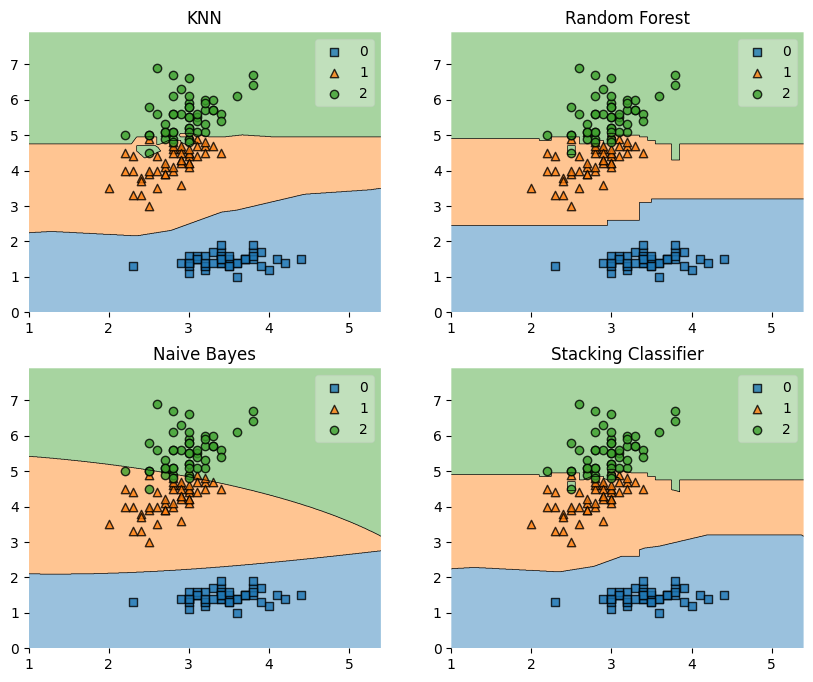

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_decision_regions

warnings.filterwarnings('ignore')

# 以 python 自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)

label= ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0, 1], repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

可以发现，基模型用 KNN、Random Forest, Naive Bayes，然后在这个基础上次级模型加一个 LogisticRegressionLogisticReg，模型测试效果有着很好的提升。

## 一些其他方法

将特征放进模型中预测，并将预测结果变化并作为新的特征加入原有特征中，再经过模型预测结果（Stacking 变化）

*可以反复预测多次将结果加入最后的特征中*

In [446]:
def Ensemble_add_feature(train, test, target, clfs):
    
    # n_folds = 5
    # skf = list(StratifiedKFold(y, n_folds=n_folds))

    train_ = np.zeros((train.shape[0], len(clfs * 2)))
    test_ = np.zeros((test.shape[0], len(clfs * 2)))

    for j, clf in enumerate(clfs):
        """依次训练各个单模型"""
        # print(j, clf)
        """使用第 1 部分作为预测，第 2 部分来训练模型，获得其预测的输出作为第 2 部分的新特征。"""
        # X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]

        clf.fit(train, target)
        y_train = clf.predict(train)
        y_test = clf.predict(test)

        ## 新特征生成
        train_[:, j * 2] = y_train ** 2
        test_[:, j * 2] = y_test ** 2
        train_[:, j + 1] = np.exp(y_train)
        test_[:, j + 1] = np.exp(y_test)
        # print('Val Auc Score: %f' % r2_score(y_predict, dataset_d2[:, j]))
        print('Method ', j)
    
    train_ = pd.DataFrame(train_)
    test = pd.DataFrame(test_)

    return train_, test_

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

data_0 = iris.data
data = data_0[:100, :]

target_0 = iris.target
target = target_0[:100]

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

# 模型融合中使用到的各个单模型
clfs = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
    ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
    ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
    GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)
]

New_train, New_test = Ensemble_add_feature(x_train, x_test, y_train, clfs)

clf = LogisticRegression()
# clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(New_train, y_train)
y_emb = clf.predict_proba(New_test)[:, 1]

print('Val Auc Score of Stacking: %f' % (roc_auc_score(y_test, y_emb)))

Method  0
Method  1
Method  2
Method  3
Method  4
Val Auc Score of Stacking: 1.000000


# 本赛题示例

In [ ]:
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb

from ...shared import get_project_path

In [449]:
## 数据读取
Train_data = pd.read_csv(get_project_path('data', 'used_car_train_20200313.csv'), sep=' ')
Test_data = pd.read_csv(get_project_path('data', 'used_car_testB_20200421.csv'), sep=' ')

print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


In [450]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [451]:
numerical_cols = Train_data.select_dtypes(exclude='object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [452]:
feature_cols = [col for col in numerical_cols if col not in ['SaleID', 'name', 'regDate', 'price']]

In [453]:
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test = Test_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 26)
X test shape: (50000, 26)


In [454]:
def Sta_inf(data):
    print('_min', np.min(data))
    print('_max', np.max(data))
    print('_mean', np.mean(data))
    print('_ptp', np.ptp(data))
    print('_std', np.std(data))
    print('_var', np.var(data))

In [455]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


In [456]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [457]:
def build_model_lr(x_train, y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train, y_train)

    return reg_model

In [458]:
def build_model_ridge(x_train, y_train):
    reg_model = linear_model.Ridge(alpha=0.8) # alphas = range(1, 100, 5)
    reg_model.fit(x_train, y_train)

    return reg_model

In [459]:
def build_model_lasso(x_train, y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train, y_train)

    return reg_model

In [460]:
def build_model_gbdt(x_train, y_train):
    estimator = GradientBoostingRegressor(loss='squared_error', subsample=0.85, max_depth=5, n_estimators=100)
    param_grid = {
        'learning_rate': [0.05, 0.08, 0.1, 0.2]
    }
    gbdt = GridSearchCV(estimator, param_grid, cv=3)
    gbdt.fit(x_train, y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_)

    return gbdt

In [461]:
def build_model_xgb(x_train, y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8, colsample_bytree=0.9, max_depth=5)
    model.fit(x_train, y_train)

    return model

In [462]:
def build_model_lgb(x_train, y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63, n_estimators=100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1]
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    print(gbm.best_params_)
    # print(gbm.best_estimator_)

    return gbm

## XGBoost 的五折交叉回归验证实现

In [463]:
## xgb
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, max_depth=7)

scores_train = []
scores = []

## 5-折交叉验证方式
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_ind, val_ind in sk.split(X_data, Y_data):
    train_x = X_data.iloc[train_ind].values
    train_y = Y_data.iloc[train_ind]
    val_x = X_data.iloc[val_ind].values
    val_y = Y_data.iloc[val_ind]

    xgr.fit(train_x, train_y)
    pred_train_xgb = xgr.predict(train_x)
    pred_xgb = xgr.predict(val_x)

    score_train = mean_absolute_error(train_y, pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y, pred_xgb)
    scores.append(score)

print('Train mae:', np.mean(scores_train))
print('Val mae:', np.mean(scores))

Train mae: 592.1189208984375
Val mae: 687.1877197265625


## 划分数据集，并用多种方法训练和预测

In [464]:
## Split data with val
x_train, x_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.3)

## Train and Predict
print('Predict LR...')
model_lr = build_model_lr(x_train, y_train)
val_lr = model_lr.predict(x_val)
subB_lr = model_lr.predict(X_test)

print('Predict Ridge...')
model_ridge = build_model_ridge(x_train, y_train)
val_ridge = model_ridge.predict(x_val)
subB_ridge = model_ridge.predict(X_test)

print('Predict Lasso...')
model_lasso = build_model_lasso(x_train, y_train)
val_lasso = model_lasso.predict(x_val)
subB_lasso = model_lasso.predict(X_test)

print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train, y_train)
val_gbdt = model_gbdt.predict(x_val)
subB_gbdt = model_gbdt.predict(X_test)

Predict LR...
Predict Ridge...
Predict Lasso...
Predict GBDT...
{'learning_rate': 0.2}


## 一般比赛中效果最为显著的两种方法

In [465]:
print('predict XGB...')
model_xgb = build_model_xgb(x_train, y_train)
val_xgb = model_xgb.predict(x_val)
subB_xgb = model_xgb.predict(X_test)

print('predict lgb...')
model_lgb = build_model_lgb(x_train, y_train)
val_lgb = model_lgb.predict(x_val)
subB_lgb = model_lgb.predict(X_test)

predict XGB...
predict lgb...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4717
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 24
[LightGBM] [Info] Start training from score 5913.622964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 24
[LightGBM] [Info] Start training from score 5900.917440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the 

In [466]:
print('Sta inf of lgb:')
Sta_inf(subB_lgb)

Sta inf of lgb:
_min -361.5647845346303
_max 90147.05390096543
_mean 5902.587933378465
_ptp 90508.61868550006
_std 7315.068693006982
_var 53510229.98341088


### 1) 加权融合

In [467]:
def Weighted_method(test_pre1, test_pre2, test_pre3, w=[1/3, 1/3, 1/3]):
    Weighted_result = w[0] * pd.Series(test_pre1) + w[1] * pd.Series(test_pre2) + w[2] * pd.Series(test_pre3)

    return Weighted_result

## Init the weights
w = [0.3, 0.4, 0.3]

## 测试验证集准确度
val_pre = Weighted_method(val_lgb, val_xgb, val_gbdt, w)
MAE_Weighted = mean_absolute_error(y_val, val_pre)
print('MAE of Weighted of val:', MAE_Weighted)

## 预测数据部分
subB = Weighted_method(subB_lgb, subB_xgb, subB_gbdt, w)
print('Sta inf:')
Sta_inf(subB)

## 生成提交文件
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subB
sub.to_csv(get_project_path('user_data', 'sub_Weighted.csv'), index=False)

MAE of Weighted of val: 722.9577939986295
Sta inf:
_min -237.01058072038853
_max 89907.27137946364
_mean 5904.809920907135
_ptp 90144.28196018403
_std 7309.333757778848
_var 53426359.98260545


In [468]:
## 与简单的 LR（线性回归）进行对比
val_lr_pred = model_lr.predict(x_val)
MAE_lr = mean_absolute_error(y_val, val_lr_pred)
print('MAE of lr:', MAE_lr)

MAE of lr: 2613.5854161758825


### 2) Stacking 融合

In [469]:
## Stacking

## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Stack_X_train = pd.DataFrame()
Stack_X_train['Method_1'] = train_lgb_pred
Stack_X_train['Method_2'] = train_xgb_pred
Stack_X_train['Method_3'] = train_gbdt_pred

Stack_X_val = pd.DataFrame()
Stack_X_val['Method_1'] = val_lgb
Stack_X_val['Method_2'] = val_xgb
Stack_X_val['Method_3'] = val_gbdt

Stack_X_test = pd.DataFrame()
Stack_X_test['Method_1'] = subB_lgb
Stack_X_test['Method_2'] = subB_xgb
Stack_X_test['Method_3'] = subB_gbdt

In [470]:
Stack_X_train.head()

,Method_1,Method_2,Method_3
0,988.008002,1132.898560,922.326876
1,1853.083861,1775.137207,1893.349132
2,992.491456,968.758484,1032.761956
3,349.163645,222.845490,195.346095
4,1365.437559,1483.774414,1417.942449


In [471]:
## level 2 method
model_lr_Stacking= build_model_lr(Stack_X_train, y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Stack_X_train)
print('MAE of Stacking-LR:', mean_absolute_error(y_train, train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Stack_X_val)
print('MAE of Stacking-LR:', mean_absolute_error(y_val, val_pre_Stacking))

## 预测集
print('Predict Stacking-LR...')
subB_Stacking = model_lr_Stacking.predict(Stack_X_test)

MAE of Stacking-LR: 626.2412901126876
MAE of Stacking-LR: 722.4600372073652
Predict Stacking-LR...


In [472]:
subB_Stacking[subB_Stacking < 10] = 10 ## 去除过小的预测值

sub = pd.DataFrame()
sub['SaleID'] = Test_data.SaleID
sub['price'] = subB_Stacking
sub.to_csv(get_project_path('user_data', 'sub_Stacking.csv'), index=False)

In [473]:
print('Sta inf:')
Sta_inf(subB_Stacking)

Sta inf:
_min 10.0
_max 92303.1650640235
_mean 5904.640048806326
_ptp 92293.1650640235
_std 7354.8844260925725
_var 54094324.92117907


# 经验总结

比赛的融合这个问题，个人的看法来说其实涉及多个层面，也是提分和提升模型鲁棒性的一种重要方法：

1. **结果层面的融合**：这种是最常见的融合方法，其可行的融合方法也有很多，比如根据结果的得分进行加权融合，还可以做 log，exp 处理等。在做结果融合的时候，有一个很重要的条件是模型结果的得分要比较近似，然后结果的差异要比较大，这样的结果融合往往有比较好的效果提升。
2. **特征层面的融合**：这个层面其实感觉不叫融合，准确来说可以叫分割，很多时候如果我们用同种模型训练，可以把特征进行切分给不同的模型，然后在后面进行模型或者结果融合，有时也能产生比较好的效果。
3. **模型层面的融合**：模型层面的融合可能就涉及模型的堆叠和设计，比如加 Stacking 层，部分模型的结果作为特征输入等，这些就需要多实验和思考了，基于模型层面的融合最好不同模型类型要有一定的差异，用同种模型不同参数的收益一般是比较小的。